## A model for classifying `pizza` or `steak` 
> https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

#### 1. Import libraries

In [1]:
# torch libraries
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# misc
import os
from datetime import datetime
from pathlib import Path
import matplotlib.pylab as plt
from PIL import Image
import numpy as np
import pandas as pd
import zipfile
import requests
import random
import glob

# check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# check torchvision
print(f"Torchvison: {torchvision.__version__}")

# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# created date
print(f"Created date: 2023:07:13 20:17:13")

# modified date
now = datetime.now().strftime("%Y:%m:%d %H:%M:%S")
print(f"Modified date: {now}")

/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 1.12.1+cu102
Torchvison: 0.13.1+cu102
Device: cuda
Created date: 2023:07:13 20:17:13
Modified date: 2023:07:25 11:28:45


#### 2. Download dataset

In [2]:
def download_dataset(save_dir: Path, url: str, file_name: str) -> None:
    """ A function for downloading dataset from an url.

    Args: 
        save_dir (Path): a directory to save the file.
        url (str): a link of a zip file.
        file_name (str): a zip file name.
    """

    # a path to the file
    file_path = save_dir.joinpath(file_name)

    # check if the file exists
    if file_path.is_file():
        print(f"The {file_name} already exists.\nSkipped downloading.")
    else:
        print(f"Downloading {file_name}...")
        # download into a save_dir
        command = f"cd {save_dir} && wget {url}"
        os.system(command=command)

        print(f"Downloaded {file_name} successfully!")

In [3]:
# url of a dataset
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"

# to save file
save_dir = Path("../../data")

# file_name
file_name = url.split("/")[-1]

# download a zip file
download_dataset(save_dir=save_dir, url=url, file_name=file_name)

The pizza_steak.zip already exists.
Skipped downloading.


In [4]:
# pizza_steak_folder
pizza_steak_folder_name = file_name.split(".")[0]

# pizza_steak_dir
pizza_steak_dir = save_dir.joinpath(pizza_steak_folder_name)

if pizza_steak_dir.is_dir():
    print(f"The {file_name} is extracted.\nSkipped extracting.")
else:
    print(f"Extracting the {file_name}...")

    # extract the zip file
    ziper = zipfile.ZipFile(save_dir.joinpath(file_name))
    ziper.extractall(save_dir)
    ziper.close()

    print(f"Extracted successfully!")

    # delete the zip file
    command = f"cd {save_dir} && rm -rf {file_name}"
    os.system(command=command)


The pizza_steak.zip is extracted.
Skipped extracting.


#### 3. Preparing Dataset

In [5]:
# train_data_dir
train_data_dir = pizza_steak_dir.joinpath("train") 

# test_data_dir
test_data_dir = pizza_steak_dir.joinpath("test") 

train_data_dir, test_data_dir

(PosixPath('../../data/pizza_steak/train'),
 PosixPath('../../data/pizza_steak/test'))

In [6]:
# os.walk in train_data_dir
for dirpaths, dirnames, filenames in os.walk(train_data_dir):
    print(f"There are {len(filenames)} images in {dirpaths}")

There are 0 images in ../../data/pizza_steak/train
There are 750 images in ../../data/pizza_steak/train/pizza
There are 750 images in ../../data/pizza_steak/train/steak


In [7]:
# os.walk in train_data_dir
for dirpaths, dirnames, filenames in os.walk(test_data_dir):
    print(f"There are {len(filenames)} images in {dirpaths}")

There are 0 images in ../../data/pizza_steak/test
There are 250 images in ../../data/pizza_steak/test/pizza
There are 250 images in ../../data/pizza_steak/test/steak


Seleted image file: ../../data/pizza_steak/test/steak/1335842.jpg
Shape of transformed image: torch.Size([3, 224, 224])
Shape of permuted image: torch.Size([224, 224, 3])


(-0.5, 223.5, 223.5, -0.5)

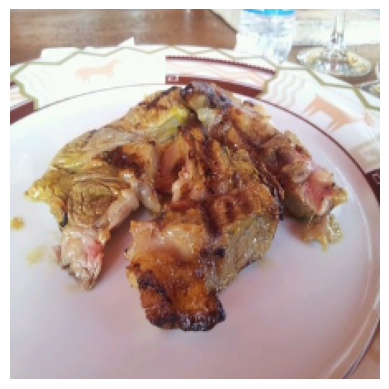

In [8]:
# display one random image
random_file = random.choice(sorted(glob.glob(str(test_data_dir.joinpath("steak/*")))))
print(f"Seleted image file: {random_file}")

# load image
image = Image.open(random_file)

# tranforms
tranform_helper = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(224,224))])
transformed_image = tranform_helper(image)
print(f"Shape of transformed image: {transformed_image.shape}")

# The desired ordering of dimensions 
# (3, 224, 224): [0, 1, 2] =>  (224, 224, 3) : [1, 2, 0] or [2, 1, 0]
permuted_image = transformed_image.permute(1,2,0) 
# permuted_image = transformed_image.permute(2,1,0) 
print(f"Shape of permuted image: {permuted_image.shape}")

# view image
plt.imshow(permuted_image)
plt.axis(False)

#### 4. Preprocessing data

In [9]:
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.465, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# train dataset
train_dataset = datasets.ImageFolder(train_data_dir, transform=data_transform)

# test datate
test_dataset = datasets.ImageFolder(test_data_dir, transform=data_transform)


In [10]:
# class name
class_names = train_dataset.classes

# print out datasets
print(f"Class names: {class_names}")
print(f"Length of train data: {len(train_dataset)}")
print(f"Length of test data: {len(test_dataset)}")

Class names: ['pizza', 'steak']
Length of train data: 1500
Length of test data: 500


In [11]:
# batch_size 
batch_size = 32

# train_dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# check one batch of train_dataloader
len(train_dataloader) # len(train_dataset / batchsize)

# check train_dataloader
print(f"{len(train_dataloader)} images in one batch")

# to verify
print(f"{round(len(train_dataset)/batch_size)} images in one batch")

47 images in one batch
47 images in one batch


#### 5. Modeling

In [13]:
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [14]:
class PizzaSteakNeuralNetwork(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=13*13*hidden_units, out_features=len(class_names))
        )
    
    def forward(self, x: torch.Tensor):

        x = self.block_1(x)
        # print(f"block_1: {x.shape}")
        x = self.block_2(x)
        # print(f"block_2: {x.shape}")
        x = self.classifier(x)
        # print(f"classifier: {x.shape}")
        return x

In [15]:
# create an instance of the model
pizza_steak_model = PizzaSteakNeuralNetwork(input_shape=3, hidden_units=10, output_shape=len(class_names))

# send model to device
pizza_steak_model.to(device)

PizzaSteakNeuralNetwork(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=2, bias=True)
  )
)

In [16]:
# # create an instance of the model
# pizza_steak_model = VGG16(num_classes=len(class_names))

# # send model to device
# pizza_steak_model.to(device)

##### 6. Training

In [18]:
# training-loop

# epochs
epochs = 20

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer 
optimizer = torch.optim.Adam(params=pizza_steak_model.parameters())

for epoch in range(epochs):

    ### TRAINING
    accumulated_train_batches = 0
    accumulated_train_losses = 0.0
    accumulated_train_accuracy = 0.0

    for inputs, targets in train_dataloader:

        # send to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # train mode
        pizza_steak_model.train()

        # forward pass
        y_logits = pizza_steak_model(inputs).squeeze()

        # calculate loss
        loss = loss_fn(y_logits.float(), targets.long())
        accumulated_train_losses += loss

        # calculate accuracy
        acc = torch.eq(targets, torch.argmax(torch.softmax(y_logits.data, dim=1), dim=1)).sum().item()
        accumulated_train_accuracy += acc

        # accumulate batches
        accumulated_train_batches += 1

        # set zero gradients
        optimizer.zero_grad()

        # calculate backpropagation
        loss.backward()

        # update parameters
        optimizer.step()
    
    train_loss = accumulated_train_losses / accumulated_train_batches
    train_acc = accumulated_train_accuracy / (accumulated_train_batches * batch_size)

    ### TESTING
    accumulated_test_batches = 0
    accumulated_test_losses = 0.0
    accumulated_test_accuracy = 0.0

    # eval mode
    pizza_steak_model.eval()
    with torch.inference_mode():
        for inputs, targets in test_dataloader:

            # send to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass
            y_logits = pizza_steak_model(inputs).squeeze()
            
            # calculate loss
            loss = loss_fn(y_logits.float(), targets.long())
            accumulated_test_losses += loss

            # calculate accuracy
            acc = torch.eq(targets, torch.argmax(torch.softmax(y_logits.data, dim=1), dim=1)).sum().item()
            accumulated_test_accuracy += acc

            # accumulate batches
            accumulated_test_batches += 1
    
    test_loss = accumulated_test_losses / accumulated_test_batches
    test_acc = accumulated_test_accuracy / (accumulated_test_batches * batch_size)

    print(f"Epoch: {epoch + 1}/{epochs} Train loss: {train_loss: .5f} | Train accuracy: {train_acc:.2f} | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}")



Epoch: 1/20 Train loss:  0.47109 | Train accuracy: 0.78 | Test loss: 0.41975 | Test accuracy: 0.79
Epoch: 2/20 Train loss:  0.45986 | Train accuracy: 0.78 | Test loss: 0.37719 | Test accuracy: 0.80
Epoch: 3/20 Train loss:  0.46729 | Train accuracy: 0.78 | Test loss: 0.35350 | Test accuracy: 0.83
Epoch: 4/20 Train loss:  0.45094 | Train accuracy: 0.79 | Test loss: 0.36489 | Test accuracy: 0.82
Epoch: 5/20 Train loss:  0.44461 | Train accuracy: 0.79 | Test loss: 0.37250 | Test accuracy: 0.83
Epoch: 6/20 Train loss:  0.46138 | Train accuracy: 0.79 | Test loss: 0.35735 | Test accuracy: 0.83
Epoch: 7/20 Train loss:  0.42920 | Train accuracy: 0.80 | Test loss: 0.35266 | Test accuracy: 0.83
Epoch: 8/20 Train loss:  0.44556 | Train accuracy: 0.79 | Test loss: 0.36148 | Test accuracy: 0.82
Epoch: 9/20 Train loss:  0.43865 | Train accuracy: 0.81 | Test loss: 0.36937 | Test accuracy: 0.81
Epoch: 10/20 Train loss:  0.44090 | Train accuracy: 0.80 | Test loss: 0.32655 | Test accuracy: 0.85
Epoch: 11